# Inferring parameters for the Beeler-Reuter Model

In this notebook, we use PINTS to create noisy data for a Beeler-Reuter system and then perform inference on the model
to try and retrieve the parameters. This should be compared with results from other notebooks, such as the FitzHugh-Nagumo
notebook.

## Creating the ForwardModel

### Variable descriptions

Firstly, we set up the system of ODEs for the Beeler-Reuter system. Below is a description of the 8 time-dependent variables
present in the model (which form a system of 8 ODEs), and we follow the notation of Keener and Sneyd (1998) Section 4.3 [$^{[1]}$](#Sources).

|variable|description|ion|
|---|-------|---|
|$V$|membrane potential|all|
|$m$|fast sodium activation gating variable|$Na^{+}$|
|$h$|fast sodium inactivation gating variable|$Na^{+}$|
|$j$|fast sodium reactivation gating variable|$Na^{+}$|
|$d$|slow inward calcium activation gating variable|$Ca^{2+}$|
|$f$|slow inward calcium inactivation gating variable|$Ca^{2+}$|
|$c$|$10^{7}[Ca]_{i}$ where $[Ca]_{i}$ is the internal calcium concentration|$Ca^{2+}$|
|$x$|outward potassium gating variable|$K^{+}$|

### Membrane potential ODE

For the ODEs, we follow some of the notation from the original Beeler and Reuter paper from 1977 [$^{[2]}$](#Sources).
The governing ODE for the membrane potential is:

\begin{equation}
    C_{m}\frac{dV}{dt} = - (I_{Na} + I_{K} + I_{x} + I_{Ca}) + I_{stim},
\end{equation}
where
\begin{equation}
    I_{Na} = (g_{Na}m^{3}hj + g_{NaC})(V - V_{Na}),
\end{equation}
\begin{equation}
    I_{K} = g_{K_1}\frac{\exp{(0.04(V - V_{K_1}))} - 1}{\exp{(0.08(V - V_{K_2}))} + \exp{(0.04(V - V_{K_2}))}} + 
            g_{K_2}\frac{V - V_{K_3}}{1 - \exp{(- 0.04(V - V_{K_3}))}},
\end{equation}
\begin{equation}
    I_{x} = g_{x}x\frac{\exp{(0.04(V - V_{x_1}))} - 1}{\exp{(0.04(V - V_{x_2}))}},
\end{equation}
\begin{equation}
    I_{Ca} = g_{Ca}fd(V - V_{Ca} + 13.0287\ln{(10^{-7}c))}.
\end{equation}

During inference, the model will have the capability to infer any of the conductances, $g_{i}$ for any subscript $i$, and any of the
Nernst (or other) potential constants, $V_{i}$. Therefore we have up to 13 parameters (6 conductances and 7 potentials) to infer. Note that 
we also fix $C_{m}$ = 1.

For the stimulating current, $I_{stim}$, we will allow flexibility for specifying the following parameters:

|parameter|description|
|---|--------|
|`stim_start`|The time at which the current is turned on.|
|`stim_period`|The length of a stimulation cycle.|
|`stim_duration`|The period for which (at the start of the stimulation cycle) the current is turned on.|
|`stim_amplitude`|The amplitude of the current.|

These will be captured in a 4-membered list, and passed to the `BeelerReuterModel` below. None of these parameters will be inferred.

### Gating variable and $Ca^{2+}$ ODEs

Below are the remaining 7 ODEs:

\begin{equation}
    \frac{dy}{dt} = \alpha_{y}(1 - y) - \beta_{y}y,
\end{equation}
\begin{equation}
    \frac{dc}{dt} = 0.07(1 - c) - I_{Ca},
\end{equation}

where $y = m, h, j, d, f, x$ and $\alpha_{y}, \beta_{y}$ are some known functions of the membrane potential, $V$ (so we will
not be inferring any parameters contained within these functions).

### Initial conditions

Finally, we will assume the following initial conditions are known (using values from CellML [$^{[3]}$](#Sources)):

\begin{equation}
    V(0) = -84.624, \qquad m(0) = 0.011, \qquad h(0) = 0.988, \qquad j(0) = 0.975, \qquad d(0) = 0.003, \qquad f(0) = 0.994, 
    \qquad x(0) = 0.0001, \qquad c(0) = 2.
\end{equation}

The goal is to try and initially infer all 13 parameters, and then see which parameters we can restrict to improve the overall inference.

In [2]:
initial_conditions = [-84.624, 0.011, 0.988, 0.975, 0.003, 0.994, 0.0001, 2]

In [3]:
from math import exp, log

import pints
import numpy as np
import scipy.integrate as si
import matplotlib.pyplot as plt

### PINTS implementation of the model

In addition to implementing the system, we give the option in the class to specify fixed parameters, if we wish to 
reduce the dimensions of the parameter space. Additionally, as we realistically would only be able to measure the membrane potential,
$V$, and the calcium concentration, $c$, we will use these as the only outputs of the system.

In [58]:
class BeelerReuterModel(pints.ForwardModel):

    def __init__(self, initial_conditions, stimulating_current, fixed_params=None, outputs=["V", "c"]):
        """Initialises the forward model with certain fixed parameters passed to the method
        as key-value pairs.
        """
        super(BeelerReuterModel, self).__init__()
        assert len(initial_conditions) == 8
        self._initial_conditions = initial_conditions

        assert len(stimulating_current) == 4
        self._stim_start, self._stim_period, self._stim_duration, self._stim_amplitude = tuple(stimulating_current)
        self._param_names = ["g_Na", "g_NaC", "g_K1", "g_K2", "g_x", "g_Ca",
                             "V_Na", "V_K1", "V_K2", "V_K3", "V_x1", "V_x2", "V_Ca"]
        self._variable_names = ["V", "m", "h", "j", "d", "f", "x", "c"]
        self._fixed_params = {}
        if fixed_params is not None:
            for k, v in fixed_params:
                if k in self._param_names:
                    self._fixed_params[k] = v

        assert 1 <= len(outputs) <= 8
        assert set(outputs).issubset(set(self._variable_names))
        self._outputs = outputs

    def get_param_names(self):
        """Returns the parameter names.
        """
        return self._param_names

    def n_outputs(self):
        """Returns number of model outputs, default to just V and c
        """
        return len(self._outputs)

    def n_parameters(self):
        """Returns number of parameters to be inferred, i.e. all non-fixed parameters.
        """
        return len(self._param_names) - len(self._fixed_params)

    def n_fixed_parameters(self):
        """Returns number of parameters we fix.
        """
        return len(self._fixed_params)

    def simulate(self, parameters, times):
        """This inherits from pints.ForwardModel, performs one forward simulation of the model.
        The list `parameters` contains only the parameters we are inferring.
        """
        g_Na, g_NaC, g_K1, g_K2, g_x, g_Ca, V_Na, V_K1, V_K2, V_K3, V_x1, V_x2, V_Ca = self._get_all_params(parameters)
        t_span = [times[0], times[len(times) - 1]]
        y0 = self._initial_conditions
        sol = si.solve_ivp(fun=self._rhs, t_span=t_span, y0=y0, 
                           t_eval=times, args=(g_Na, g_NaC, g_K1, g_K2, g_x, g_Ca, 
                                               V_Na, V_K1, V_K2, V_K3, V_x1, V_x2, V_Ca,
                                               self._stim_start, self._stim_period, self._stim_duration, self._stim_amplitude))

        # Now we find which outputs we wish to use
        output_indices = [self._variable_names.index(variable) for variable in self._outputs]
        return np.array([sol.y[index, :] for index in output_indices]).transpose()

    def _get_all_params(self, parameters):
        """We need a list of 13 parameters, so we check to see which parameters are fixed, and which are not.
        We increment j each time a non-fixed parameter is reached.
        """
        all_parameters = []
        j = 0
        for param in self._param_names:
            if param in self._fixed_params.keys():
                all_parameters.append(self._fixed_params[param])
            else:
                all_parameters.append(parameters[j])
                j += 1
        return tuple(all_parameters)

    @staticmethod
    def _rhs(t, y, g_Na, g_NaC, g_K1, g_K2, g_x, g_Ca, 
             V_Na, V_K1, V_K2, V_K3, V_x1, V_x2, V_Ca,
             stim_start, stim_period, stim_duration, stim_amplitude):
        """The right hand side function of the Beeler-Reuter system.
        """
        # Variables
        V, m, h, j, d, f, x, c = tuple(list(y))

        # Currents
        I_Na = (g_Na * (m**3) * h * j + g_NaC) * (V - V_Na)
        I_K = g_K1 * (exp(0.04 * (V - V_K1)) - 1) / (exp(0.08 * (V - V_K2)) + exp(0.04 * (V - V_K2))) + g_K2 * (V - V_K3) / (1 - exp(-0.04 * (V - V_K3)))
        I_x = g_x * x * (exp(0.04 * (V - V_x1)) - 1) / exp(0.04 * (V - V_x2))
        I_Ca = g_Ca * d * f * (V - V_Ca + 13.0287 * (log(c) - 7 * log(10)))

        # Stimulation parameters
        if (t - stim_start) % stim_period <= stim_duration:
            I_stim = stim_amplitude
        else:
            I_stim = 0

        # Membrane potential ODE
        V_dot = - (I_Na + I_K + I_x + I_Ca) + I_stim

        # Gating variable ODEs
        m_dot = (V + 47) / (1 - exp(-0.1 * (V + 47))) * (1 - m) - 40 * exp(-0.056 * (V + 72)) * m
        h_dot = 0.126 * exp(-0.25 * (V + 77)) * (1 - h) - 1.7 / (1 + exp(-0.082 * (V + 22.5))) * h
        j_dot = 0.055 * exp(-0.25 * (V + 78)) / (1 + exp(-0.2 * (V + 78))) * (1 - j) - 0.3 / (1 + exp(-0.1 * (V + 32))) * j
        d_dot = 0.095 * exp(-0.01 * (V + -5)) / (exp(-0.072 * (V + -5)) + 1) * (1 - d) - 0.07 * exp(-0.017 * (V + 44)) / (exp(0.05 * (V + 44)) + 1) * d
        f_dot = 0.012 * exp(-0.008 * (V + 28)) / (exp(0.15 * (V + 28)) + 1) * (1 - f) - 0.0065 * exp(-0.02 * (V + 30)) / (exp(-0.2 * (V + 30)) + 1) * f
        x_dot = 0.0005 * exp(0.083 * (V + 50)) / (exp(0.057 * (V + 50)) + 1) * (1 - x) - 0.0013 * exp(-0.06 * (V + 20)) / (exp(-0.04 * (V + 20)) + 1) * x

        # Calcium concentration ODE
        c_dot = 0.07 * (1 - c) - I_Ca
        return np.array([V_dot, m_dot, h_dot, j_dot, d_dot, f_dot, x_dot, c_dot])


## Generating data for the model

### Simulating the system

Next, we will generate some data for the model using known parameter values. We use the ones chosen by Keener and Sneyd (pg 150) [$^{[1]}$](#Sources), tabulated below:

|parameter|value|
|-----|-----|
|$g_{Na}$|4|
|$g_{NaC}$|0.003|
|$g_{K_1}$|1.4|
|$g_{K_2}$|0.07|
|$g_{x}$|0.8|
|$g_{Ca}$|0.09|
|$V_{Na}$|50|
|$V_{K_1}$|-85|
|$V_{K_2}$|-53|
|$V_{K_3}$|-23|
|$V_{x_1}$|-77|
|$V_{x_2}$|-35|
|$V_{Ca}$|-82.3|

The below stimulation parameters are related to ones chosen in CellML [$^{[3]}$](#Sources).

In [45]:
fixed_params = None
# Stimulation parameters [stim_start, stim_period, stim_duration, stim_amplitude]
stim_params = [1, 1000, 1, 25]

In [59]:
model = BeelerReuterModel(initial_conditions, stim_params, fixed_params=fixed_params, outputs=["V", "c"])
param_names = model.get_param_names()
parameters = np.array([4, 0.003, 1.4, 0.07, 0.8, 0.09, 50, -85, -53, -23, -77, -35, -82.3])
times = np.arange(0, 400, 4)
data = model.simulate(parameters, times)

### Adding noise to the system

We now utilise PINTS noise generators to create some noisy data for the system. Specifically, `pints.noise.independent`
creates independent Gaussian noise iid $\mathcal{N}(0, \sigma)$.

In [60]:
sigma = 1
noisy_data = data + pints.noise.independent(sigma, data.shape)

### Plotting time series and phase plane

In [9]:
import matplotlib.pyplot as plt

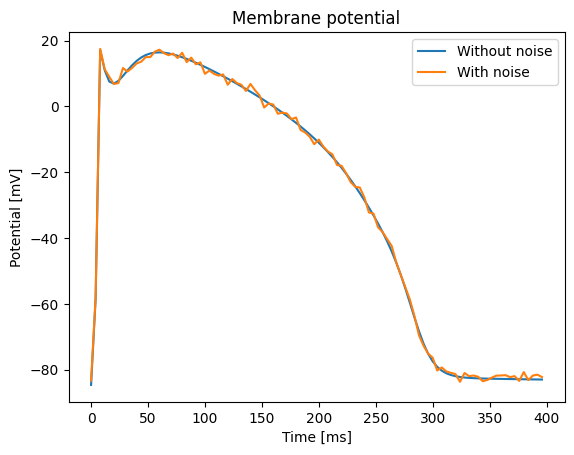

In [54]:
V, c = data[0, :], data[1, :]
noisy_V, noisy_c = noisy_data[0, :], noisy_data[1, :]
plt.plot(times, V, label="Without noise")
plt.plot(times, noisy_V, label="With noise")
plt.xlabel("Time [ms]")
plt.ylabel("Potential [mV]")
plt.legend()
plt.title("Membrane potential")
plt.savefig("simulation_outputs/time_series_V.png")

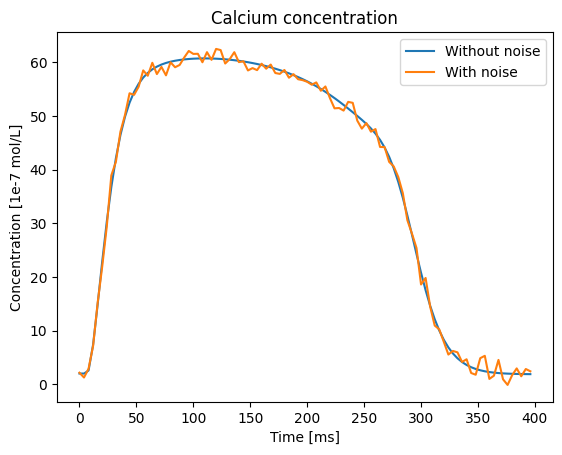

In [55]:
plt.plot(times, c, label="Without noise")
plt.plot(times, noisy_c, label="With noise")
plt.xlabel("Time [ms]")
plt.ylabel("Concentration [1e-7 mol/L]")
plt.legend()
plt.title("Calcium concentration")
plt.savefig("simulation_outputs/time_series_c.png")

## Using PINTS to perform inference

We will now perform Bayesian inference on the model to try and recover the values of the input parameters.

### `LogPrior`, `LogLikelihood` and `LogPosterior`

In [61]:
problem = pints.MultiOutputProblem(model, times, noisy_data)

In [10]:
log_prior = pints.ComposedLogPrior(
    pints.UniformLogPrior([0.001], [0.1]), # epsilon
    pints.TruncatedGaussianLogPrior(1, 1, 0, np.inf), # A
    pints.UniformLogPrior([-1], [0]), # alpha (between -1 and 0)
    pints.TruncatedGaussianLogPrior(1, 1, 0, np.inf), # gamma
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf), # v0
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf), # w0
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf), # sigma_V
    pints.TruncatedGaussianLogPrior(0, 1, 0, np.inf) # sigma_c
)

C:\Users\matth\AppData\Local\Temp\ipykernel_23072\4115627522.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  pints.UniformLogPrior([0.001], [0.1]), # epsilon
C:\Users\matth\AppData\Local\Temp\ipykernel_23072\4115627522.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  pints.UniformLogPrior([-1], [0]), # alpha (between -1 and 0)


In [11]:
log_likelihood = pints.GaussianLogLikelihood(problem)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

### Initialising chains

In [16]:
num_chains = 4
xs = log_prior.sample(num_chains)

### Performing inference

In [17]:
n_params = log_prior.n_parameters()
transform = pints.RectangularBoundariesTransformation([0.001, 0, -4, 0, 0, 0, 0], 
                                                      [4, 4, 0, 4, 4, 4, 4])
mcmc = pints.MCMCController(log_posterior, num_chains, xs, method=pints.PopulationMCMC, transformation=transform)
max_iterations = 80000
mcmc.set_max_iterations(max_iterations)

chains = mcmc.run()

Using Population MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval.  i     j     Ex. i     j     Ex. i     j     Ex. i     j     Ex. Time m:s
0     4      0     1     no  0     1     no  0     1     no  0     1     no    0:00.0
1     8      4     6     no  6     2     yes 6     2     yes 3     4     yes   0:00.1
2     12     2     8     no  8     4     yes 3     8     yes 0     9     yes   0:00.2
3     16     3     5     yes 6     5     yes 0     6     yes 5     0     yes   0:00.2
20    84     0     2     no  6     0     yes 2     7     no  9     0     yes   0:00.9
40    164    7     0     no  6     9     yes 2     0     yes 0     9     no    0:01.9
60    244    6     0     no  9     8     yes 1     0     yes 6     0     yes   0:02.7
80    324    3     0     no  5     3     no  4     3     yes 5     0     no    0:03.6
100   404    1     3     yes 5     9     no  3     6     yes 6     5     yes   0:04.5
120   484    9     5     no  3     1     yes 8     2     no  9     3 

C:\Users\matth\AppData\Local\Temp\ipykernel_18532\2295199633.py:69: RuntimeWarning: overflow encountered in scalar multiply
  return np.array([(A * v * (v - alpha) * (1 - v) - w) / epsilon,


380   1524   7     5     no  7     1     no  0     9     no  5     0     no    0:20.3
400   1604   7     0     no  4     2     no  2     6     no  3     0     no    0:21.4
420   1684   5     1     yes 5     0     no  9     6     no  7     0     no    0:22.9
440   1764   3     7     no  4     6     no  2     5     no  4     8     no    0:24.0
460   1844   7     2     no  3     6     no  2     6     no  0     1     no    0:25.3
480   1924   6     8     no  1     2     yes 8     3     no  3     2     no    0:26.6
500   2004   0     4     no  9     3     no  5     6     yes 9     1     no    0:27.7
520   2084   3     8     no  5     4     yes 0     9     no  8     9     no    0:29.2
540   2164   6     7     no  8     9     no  6     8     no  6     5     no    0:30.2
560   2244   1     3     no  2     0     no  7     0     no  7     6     yes   0:31.5
580   2324   7     6     no  0     3     no  4     6     no  2     7     no    0:32.4
600   2404   4     2     no  4     1     yes 1     9  

C:\Users\matth\AppData\Local\Temp\ipykernel_18532\2295199633.py:69: RuntimeWarning: overflow encountered in scalar divide
  return np.array([(A * v * (v - alpha) * (1 - v) - w) / epsilon,


1920  7684   3     2     yes 9     4     no  5     3     no  8     9     no    1:51.2
1940  7764   5     7     no  4     2     no  2     5     no  8     4     no    1:52.7
1960  7844   5     4     yes 6     2     no  9     6     no  4     8     no    1:53.9
1980  7924   4     1     no  3     9     no  4     5     no  0     4     no    1:55.1
2000  8004   9     1     no  9     1     no  9     8     no  3     5     no    1:56.9
2020  8084   0     7     no  4     5     yes 2     9     no  8     4     no    1:59.4
2040  8164   6     0     no  2     7     no  6     4     no  0     4     no    2:01.3
2060  8244   5     6     no  3     2     yes 1     7     no  1     4     no    2:03.2
2080  8324   6     3     no  8     9     no  5     3     no  2     5     no    2:04.6
2100  8404   0     2     no  3     4     yes 0     5     no  0     9     no    2:05.6
2120  8484   9     0     no  3     6     no  8     6     no  2     6     no    2:07.0
2140  8564   7     3     no  7     3     no  7     3  

### Saving chains

In [12]:
import pandas as pd

In [13]:
all_param_names = model.get_param_names() + ["sigma_v"]

In [22]:
for i, chain in enumerate(chains):
    df = pd.DataFrame(chain, columns=all_param_names)
    df.to_csv(f"chain_data/all_params_osc_v/chain_{i}.csv")

## Plots

### Recovering chains from .csv files

In [14]:
num_chains = 4
list_of_chains = []
for i in range(num_chains):
    df = pd.read_csv(f"chain_data/all_params_osc_v/chain_{i}.csv", index_col=0)
    chain = df.to_numpy()
    list_of_chains.append(chain)
chains = np.array(list_of_chains)

### Trace plots

In [18]:
import setuptools

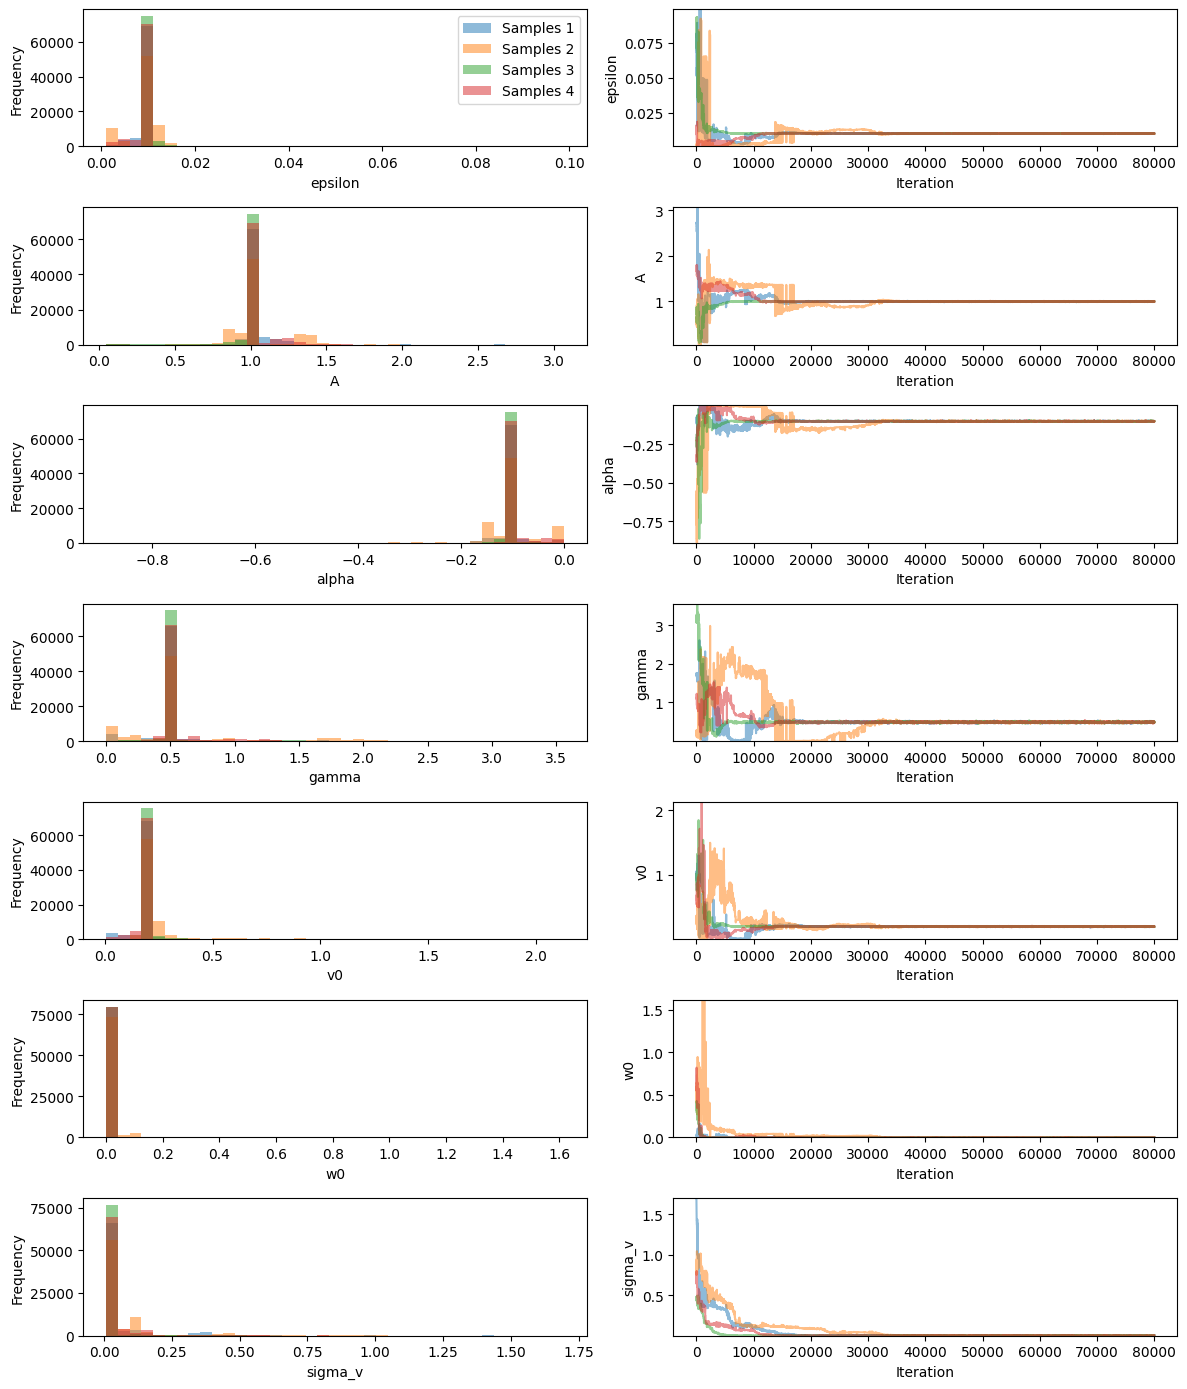

In [19]:
import pints.plot
pints.plot.trace(chains, parameter_names=all_param_names)
plt.show()

### Diagnosing using $\hat{R}$

Here we find the $\hat{R}$ measure for the inference for all different parameters. For well mixed and stationary chains, $\hat{R}$ is close to $1$.

In [20]:
r_hat_values = pints.rhat(chains, warm_up=0.5)
for i in range(len(all_param_names)):
    print(f"R_hat value for {all_param_names[i]}: {round(r_hat_values[i], 5)}")

R_hat value for epsilon: 1.00372
R_hat value for A: 1.00373
R_hat value for alpha: 1.00244
R_hat value for gamma: 1.00257
R_hat value for v0: 1.00243
R_hat value for w0: 1.00176
R_hat value for sigma_v: 1.00263


We will now discount the first half of the iterations.

In [22]:
chains = chains[:, int(max_iterations / 2):]

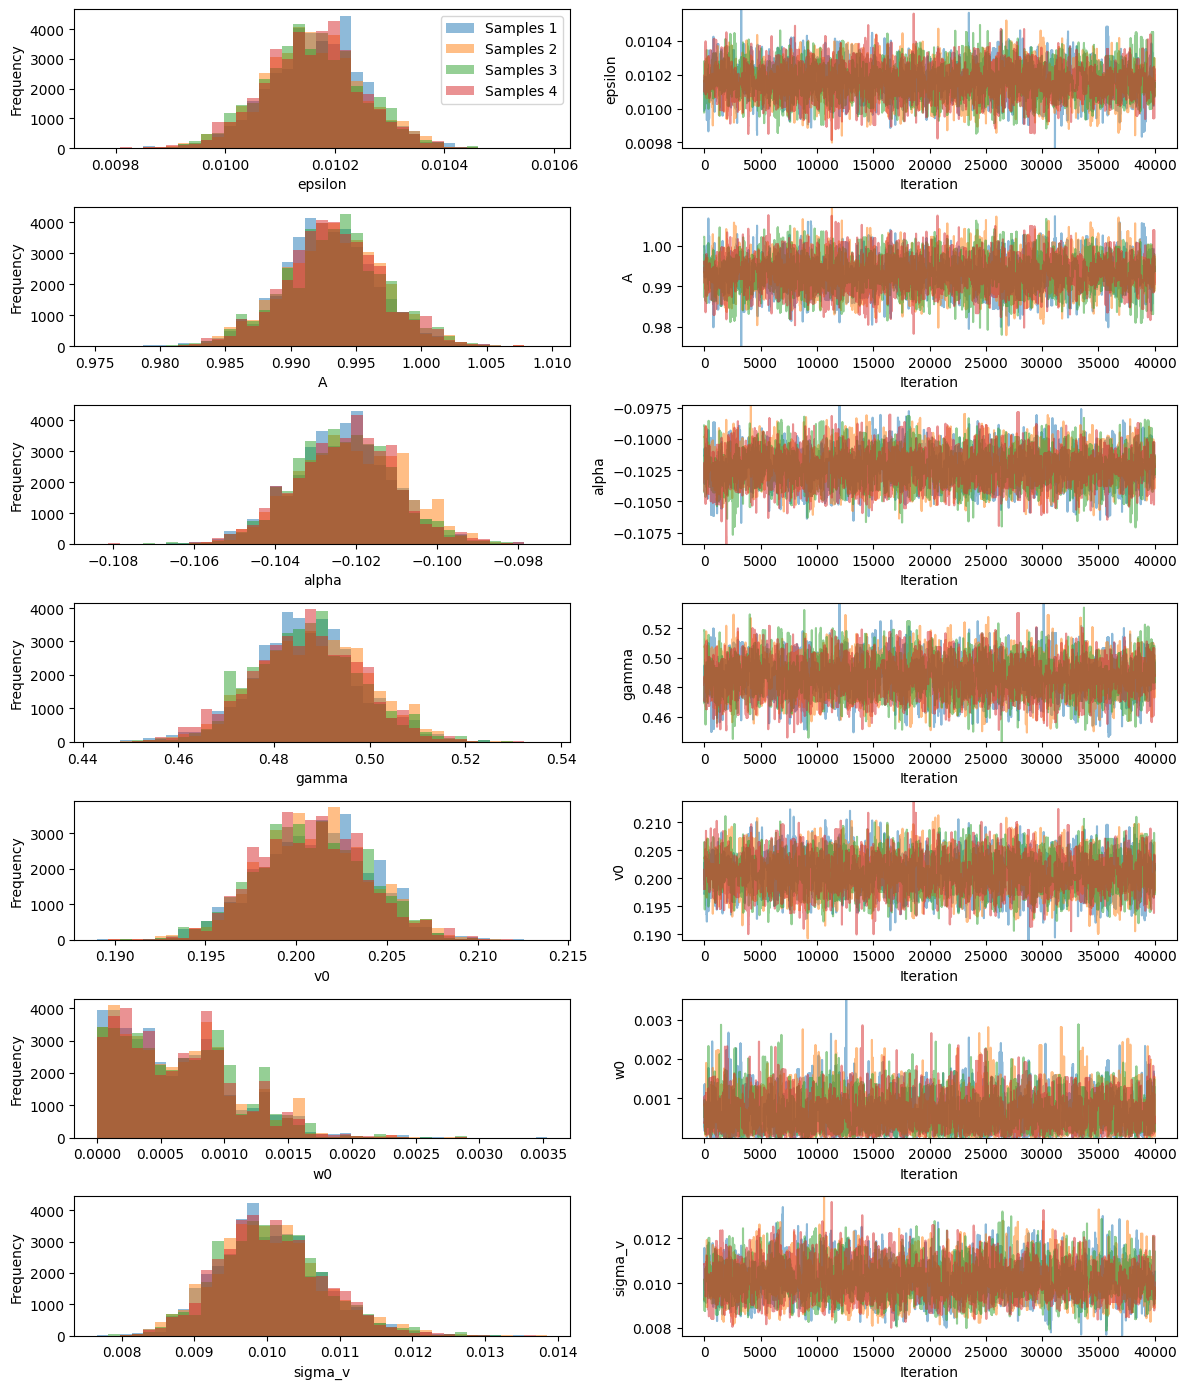

In [23]:
pints.plot.trace(chains, parameter_names=all_param_names)
plt.show()

### Predicted time series plots

#### Chain 1

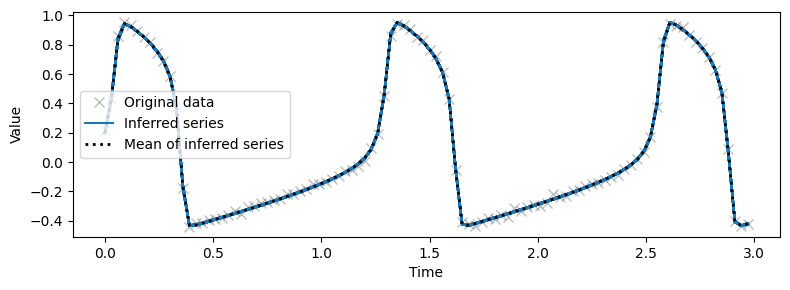

In [24]:
pints.plot.series(chains[0, :], problem)
plt.savefig("inference_outputs/series_osc_v.png")

#### Chain 2

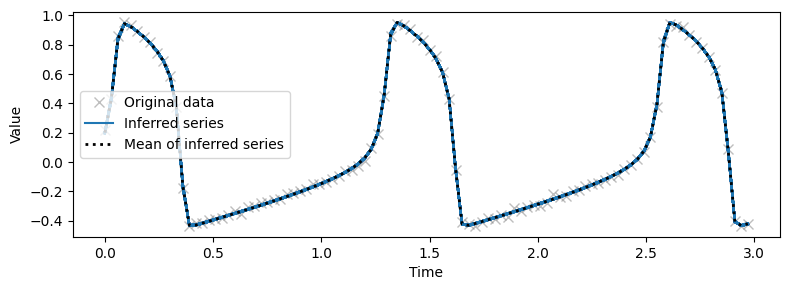

In [25]:
pints.plot.series(chains[1, :], problem)
plt.show()

#### Chain 3

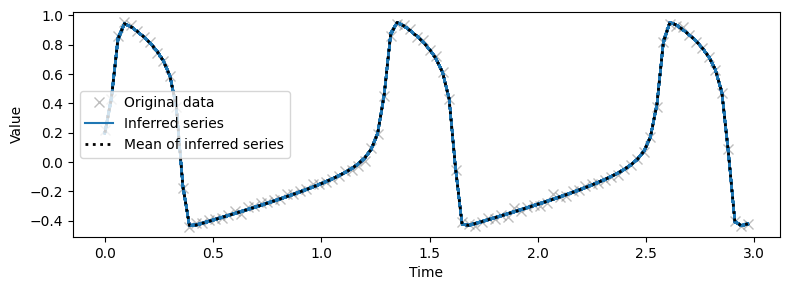

In [26]:
pints.plot.series(chains[2, :], problem)
plt.show()

#### Chain 4

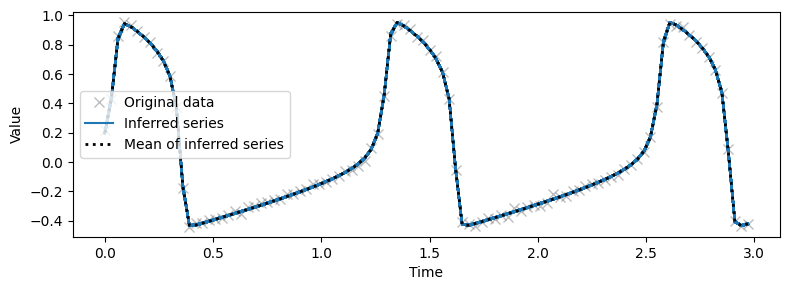

In [27]:
pints.plot.series(chains[3, :], problem)
plt.show()

### Pairwise plots

Here we will see which parameters are most correlated.

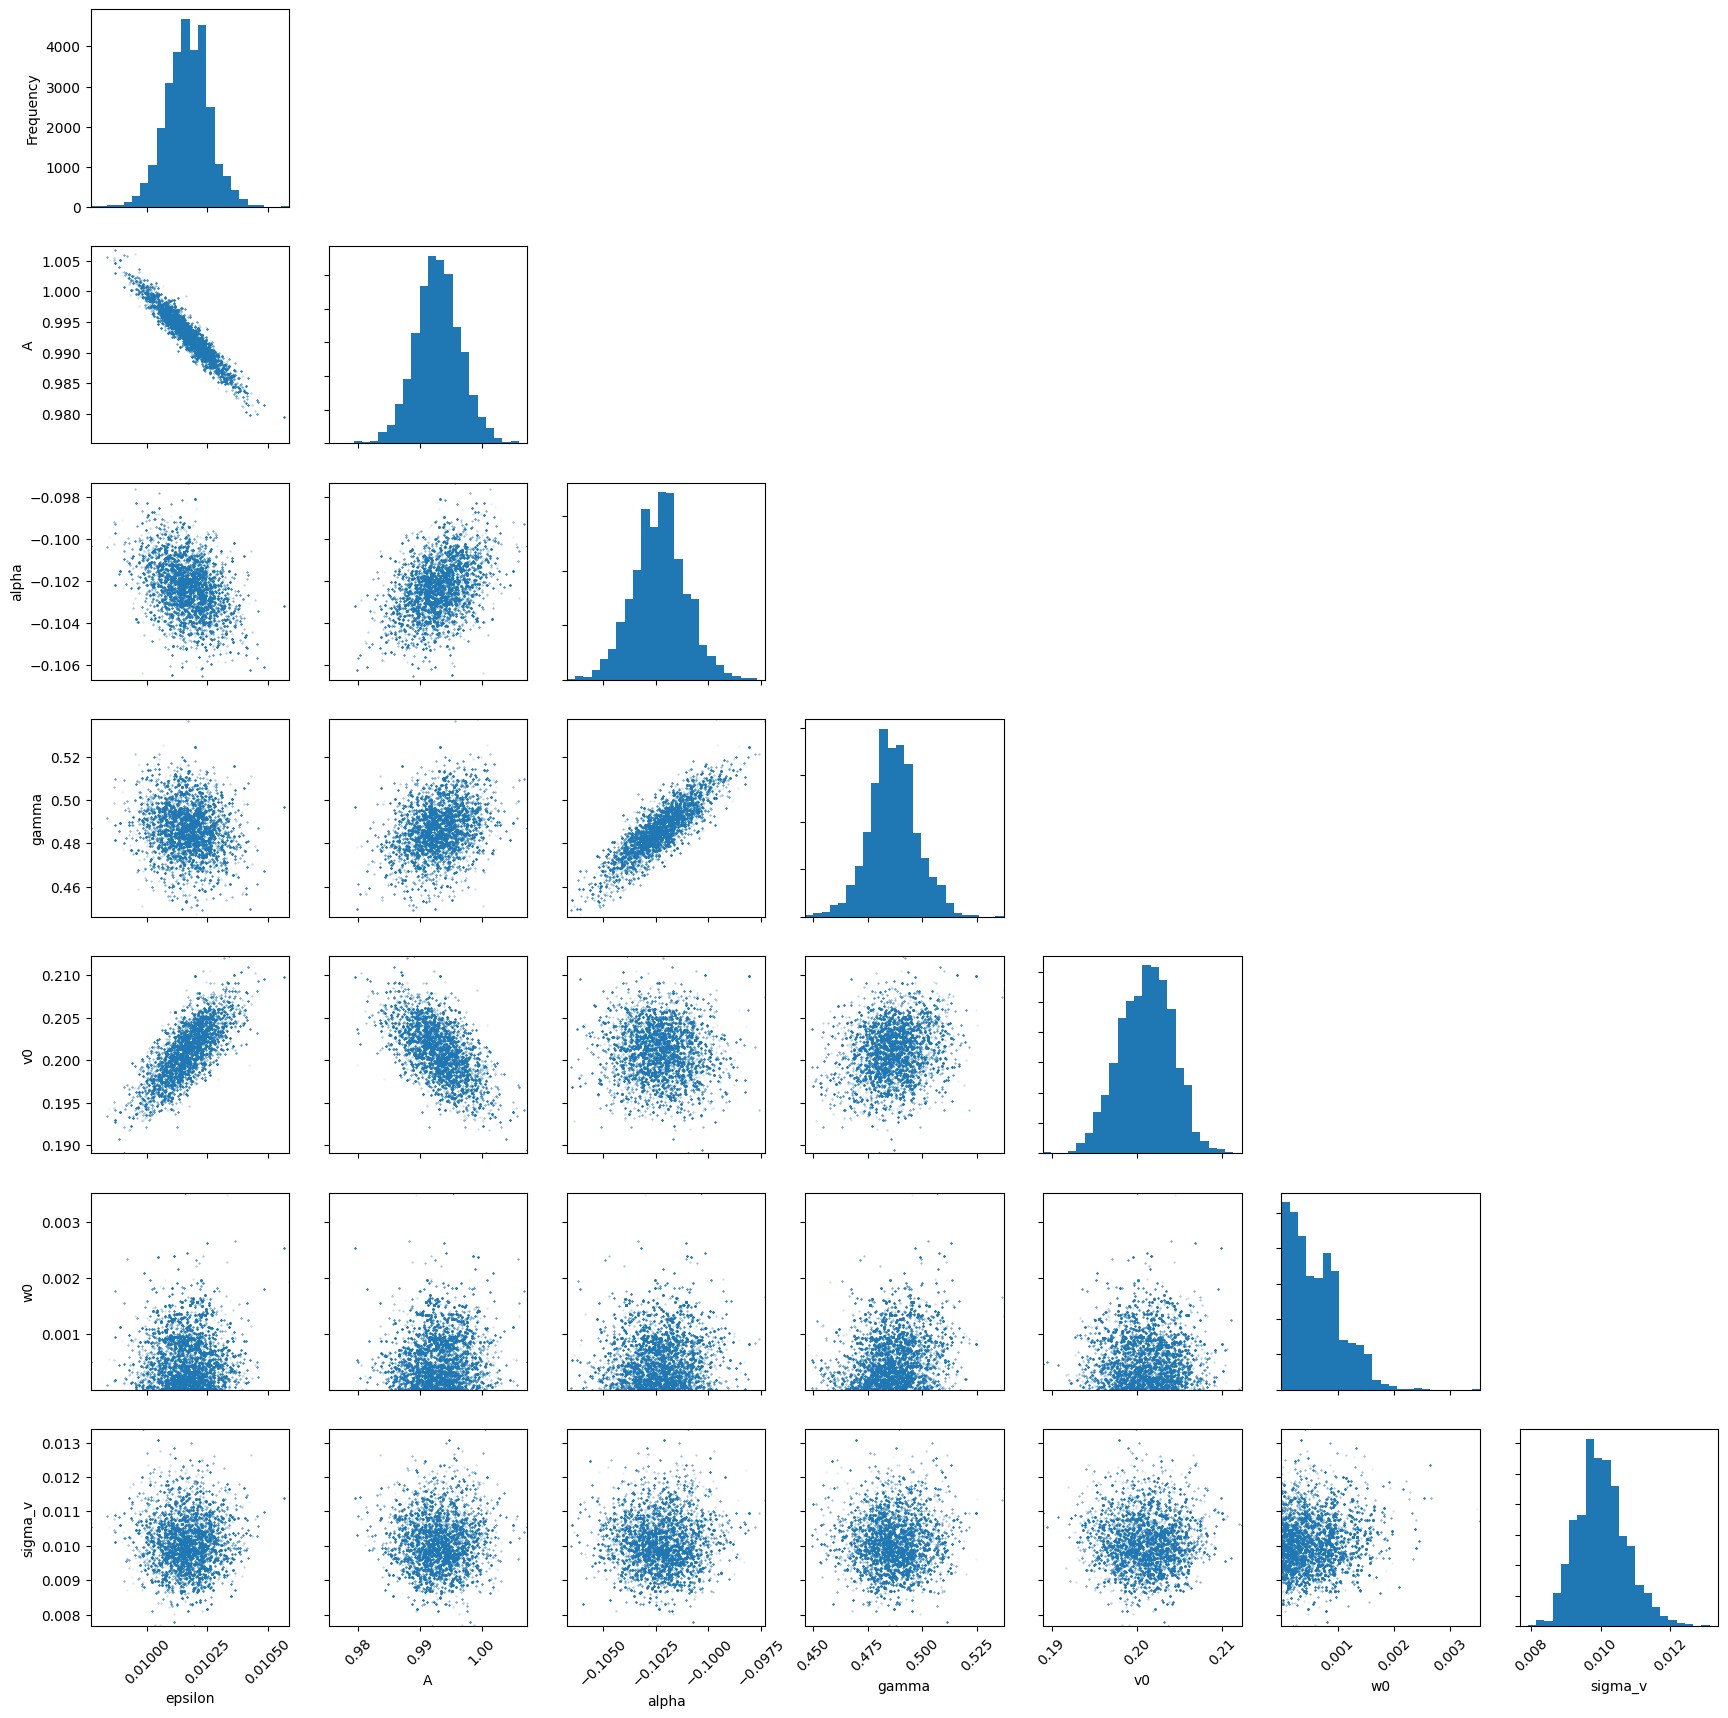

In [28]:
pints.plot.pairwise(chains[0, :], parameter_names=all_param_names)
plt.savefig("inference_outputs/pairwise_osc_v.png")

## Extracting posterior distributions

Finally, we will use the stationary chain data to extract posteriors. Assuming chains have converged, we can use their 
iterations as samples from the posterior.

In [29]:
chains_df = pd.DataFrame(columns=all_param_names + ['chain'])
for i in range(num_chains):
    chain_i_df = pd.DataFrame(chains[i], columns=all_param_names)
    chain_i_df['chain'] = [i] * len(chain_i_df)
    chains_df = pd.concat([chains_df, chain_i_df], ignore_index=True)

C:\Users\matth\AppData\Local\Temp\ipykernel_23072\1106702706.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  chains_df = pd.concat([chains_df, chain_i_df], ignore_index=True)


Mean epsilon: 0.010161218542890345, std dev epsilon: 8.992756545685076e-05
Mean A: 0.9932059578732544, std dev A: 0.0037766611358094394
Mean alpha: -0.1022490835660465, std dev alpha: 0.0012713437983833593
Mean gamma: 0.487162916918136, std dev gamma: 0.011436754700268207
Mean v0: 0.20096661283385137, std dev v0: 0.003026557661052951
Mean w0: 0.0006368718733640415, std dev w0: 0.00045114460599508365


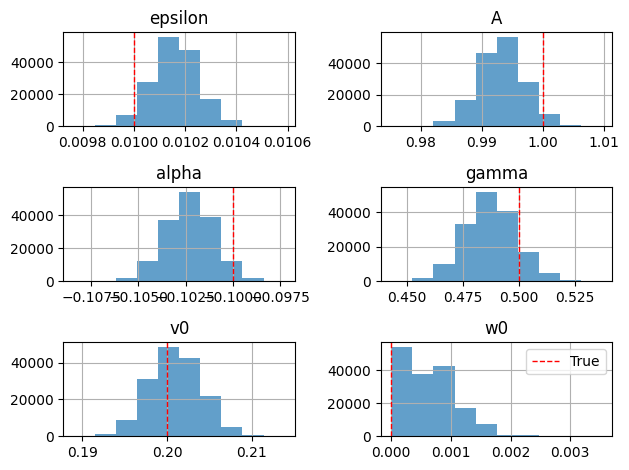

In [30]:
for name in param_names:
    print(f"Mean {name}: {np.mean(chains_df[name])}," 
          f" std dev {name}: {np.std(chains_df[name])}")
histograms = chains_df.hist(column=param_names, alpha=0.7)
for i in range(3):
    for j in range(2):
        ax = histograms[i][j]
        ax.axvline(parameters[i * 2 + j], color='r', linestyle='dashed', linewidth=1, label="True")
plt.tight_layout()
plt.legend()
plt.savefig("inference_outputs/posteriors_osc_v.png")

## Sources
$^{[1]}$ J. Keener and J. Sneyd (1998) - Mathematical Physiology https://link.springer.com/book/10.1007/b98841

$^{[2]}$ G. W. Beeler and H. Reuter, RECONSTRUCTION OF THE ACTION POTENTIAL OF
VENTRICULAR MYOCARDIAL FIBRES, J. Physiol. **268** (1977), pp. 177-210 https://doi.org/10.1113/jphysiol.1977.sp011853

$^{[3]}$ P. Noble, F. Fenton, cellML - Beeler, Reuter 1997, date accessed: 22/03/24, https://models.cellml.org/e/1